# Number of Spot and Relet vessels over the last year

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
And put your API key in a `SIGNAL_OCEAN_API_KEY` environment variable.

## Number of spot and number of relet vessels over time
The data frame format makes it very easy to generate a supply trend plot.

We'll generate a supply trend for 365 days period and we are interested to detect the number of spot and relet vessels which open in specific areas

In [1]:
from datetime import date, timedelta,time
from signal_ocean import PortAPI, VesselClassAPI,PortFilter,VesselClassFilter,Connection
from signal_ocean.historical_tonnage_list import VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass, OperationalStatus
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI
from signal_ocean.historical_tonnage_list import IndexLevel

connection = Connection('262c367b7782482e99f09793570eee9a')

port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like='aframax'))[0]
port = port_api.get_ports(PortFilter(name_like='ceyhan'))[0]
laycanEndInDays = 300
start_date = date.today() - timedelta(days=365)
end_date = date.today()

vessel_filter = VesselFilter(
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5
)


htl_for_supply_trend = htl_api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycanEndInDays,
    start_date,
    end_date,
    vessel_filter=vessel_filter,
    time=time(hour=6)
)

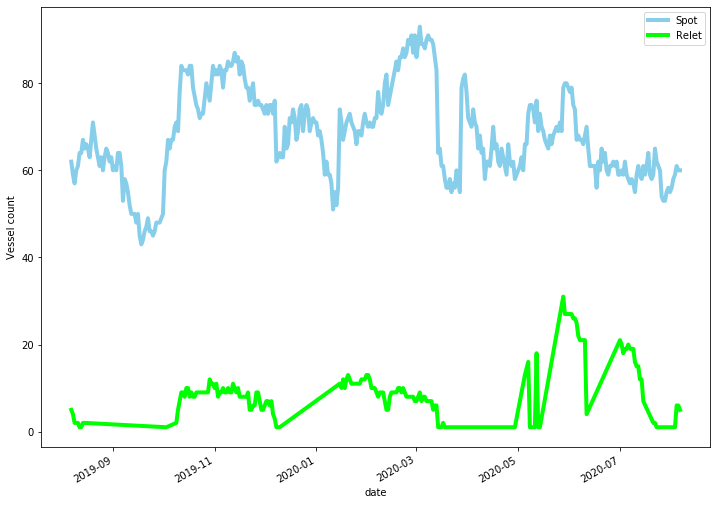

In [4]:
supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
open_areas_of_interest = ['Iberian Atlantic Coast', 'British Isles','North Sea', 'Baltic Sea Low', 'Baltic Sea Upper', 'Continent']
areas_filter = supply_trend_data_frame.open_narrow_area_point_in_time.isin(open_areas_of_interest)
spot_filter = supply_trend_data_frame.market_deployment_point_in_time == 'Spot'
relet_filter = supply_trend_data_frame.market_deployment_point_in_time == 'Relet'
spot_vessels = supply_trend_data_frame[spot_filter & areas_filter].groupby(IndexLevel.DATE, sort=True).size()
relet_vessels = supply_trend_data_frame[relet_filter & areas_filter].groupby(IndexLevel.DATE, sort=True).size()



ax = spot_vessels.plot(markerfacecolor='blue', color='skyblue', linewidth=4, label='Spot', figsize=(12, 9))
ax2 = relet_vessels.plot(ax=ax, markerfacecolor='darkgreen', color='lime',linewidth=4, label='Relet', figsize=(12, 9))

ax2.set_ylabel('Vessel count')
ax2.legend()


## Number ballast unficed vessels in Med - Black sea

Now we will use the same example to generate a supply trend for 365 days period to detect ballast unfixed vessels in Med and Black sea

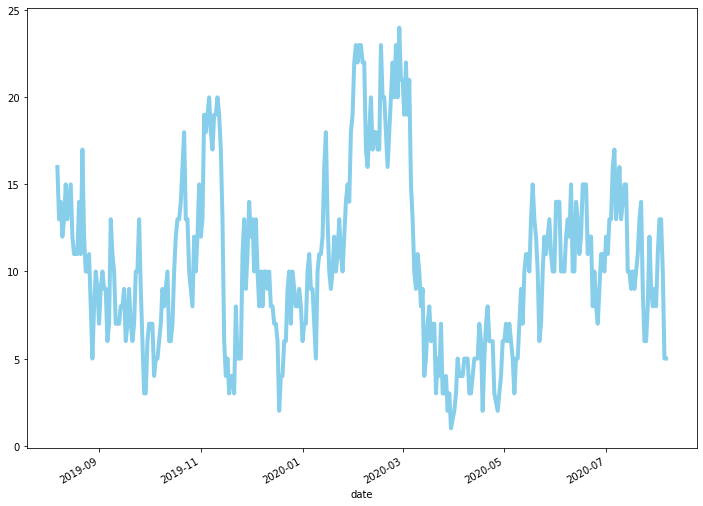

In [10]:
supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
open_areas_of_interest = ['East Mediterranean', 'Central Mediterranean','West Mediterranean', 'Black Sea']

operationalStatuses = [OperationalStatus.BALLAST_UNFIXED]
areas_filter = supply_trend_data_frame.open_narrow_area_point_in_time.isin(open_areas_of_interest)
operational_status_filter = supply_trend_data_frame.operational_status_point_in_time.isin(operationalStatuses)

aggregatedData = supply_trend_data_frame[operational_status_filter & areas_filter].groupby(IndexLevel.DATE, sort=True).size()


ax = aggregatedData.plot(markerfacecolor='blue', color='skyblue', linewidth=4, label='Spot', figsize=(12, 9))

ax2.set_ylabel('Vessel count')
ax2.legend()